In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Housing.csv')
df = df.sample(frac = 1, random_state = 3)
df

,Unnamed: 0,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
399,400,85000.0,7231,3,1,2,yes,yes,yes,no,yes,0,yes
251,252,52000.0,3520,2,2,1,yes,no,yes,no,no,0,no
455,456,75000.0,3800,3,1,2,yes,yes,yes,no,no,1,yes
466,467,54000.0,2856,3,1,3,yes,no,no,no,no,0,yes
129,130,127000.0,4600,3,2,2,yes,yes,no,no,yes,2,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,481,89500.0,6000,4,1,3,yes,yes,yes,no,no,0,yes
422,423,61100.0,3400,3,1,2,yes,no,yes,no,no,2,yes
119,120,116000.0,6840,5,1,2,yes,yes,yes,no,yes,1,no
256,257,71000.0,4410,4,3,2,yes,no,yes,no,no,2,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 399 to 249
Data columns (total 13 columns):
Unnamed: 0    546 non-null int64
price         546 non-null float64
lotsize       546 non-null int64
bedrooms      546 non-null int64
bathrms       546 non-null int64
stories       546 non-null int64
driveway      546 non-null object
recroom       546 non-null object
fullbase      546 non-null object
gashw         546 non-null object
airco         546 non-null object
garagepl      546 non-null int64
prefarea      546 non-null object
dtypes: float64(1), int64(6), object(6)
memory usage: 59.7+ KB


In [4]:
df = df.drop('Unnamed: 0', axis = 1)

In [5]:
obj_cols = list(df.select_dtypes(include = 'object').columns)
obj_cols

['driveway', 'recroom', 'fullbase', 'gashw', 'airco', 'prefarea']

In [6]:
for col in obj_cols: 
    print(df[col].value_counts())

yes    469
no      77
Name: driveway, dtype: int64
no     449
yes     97
Name: recroom, dtype: int64
no     355
yes    191
Name: fullbase, dtype: int64
no     521
yes     25
Name: gashw, dtype: int64
no     373
yes    173
Name: airco, dtype: int64
no     418
yes    128
Name: prefarea, dtype: int64


In [7]:
df = pd.get_dummies(df, columns = obj_cols, drop_first = True)

In [8]:
y = df['price']
X = df.drop('price', axis = 1)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

### Recursive Feature Elimination

In [17]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [18]:
print(X_train.shape)

(382, 11)


In [19]:
no_ofcols = X_train.shape[1]
r2score = []
rmse = []

lr = LinearRegression()

for i in range(no_ofcols):
    rfe = RFE(lr, n_features_to_select = i+1)
    rfe.fit(X_train, y_train)
    y_test_pred = rfe.predict(X_test)
    r2 = r2_score(y_test, y_test_pred)
    rms = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2score.append(r2)
    rmse.append(rms)
    

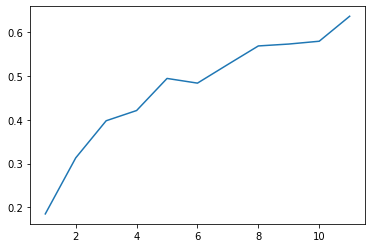

In [21]:
plt.plot(range(1,12), r2score)


In [22]:
r2score

[0.1850299788183395,
 0.3131259692895041,
 0.39798607981680967,
 0.42136297775317877,
 0.4947101901228007,
 0.48399829696985786,
 0.5267337241770209,
 0.568988286201481,
 0.5733244027708126,
 0.5797432558608717,
 0.6368778022054269]

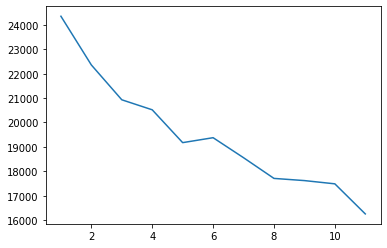

In [23]:
plt.plot(range(1,12), rmse)

In [24]:
rmse

[24352.18631280027,
 22356.596548621514,
 20930.056841332,
 20519.66421349967,
 19175.090001059732,
 19377.275258922353,
 18557.51927456962,
 17709.719303472873,
 17620.411380887675,
 17487.369511411336,
 16255.245772193812]

In [25]:
rfe = RFE(lr, n_features_to_select = 8)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=8, step=1, verbose=0)

In [27]:
pd.DataFrame(rfe.ranking_, index = X.columns, columns = ['selected'])

,selected
lotsize,4
bedrooms,3
bathrms,1
stories,1
garagepl,1
driveway_yes,1
recroom_yes,1
fullbase_yes,2
gashw_yes,1
airco_yes,1


### Hyper parameter tuning approach to find the optimal number of features to keep

In [30]:
from sklearn.model_selection import KFold, GridSearchCV

params = {'n_features_to_select': list(range(1,12))}
lr = LinearRegression()
rfe = RFE(lr)

kf = KFold(n_splits = 3, random_state = 3)

gsearch = GridSearchCV(rfe, param_grid = params, scoring = 'r2', cv = kf, return_train_score = True)

gsearch.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=3, shuffle=False),
             error_score='raise-deprecating',
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [31]:
gsearch.best_params_

{'n_features_to_select': 11}

In [32]:
pd.DataFrame(gsearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.010305,4.696283e-04,0.001662,4.701903e-04,1,{'n_features_to_select': 1},0.217671,0.285813,0.289996,0.264493,0.033152,11,0.292885,0.254951,0.256315,0.268050,0.017569
1,0.009309,4.695722e-04,0.001330,4.700779e-04,2,{'n_features_to_select': 2},0.307654,0.448551,0.298140,0.351448,0.068772,10,0.451576,0.374300,0.375353,0.400410,0.036182
2,0.010639,1.695108e-03,0.001663,4.706427e-04,3,{'n_features_to_select': 3},0.356029,0.523029,0.282677,0.387245,0.100576,9,0.515776,0.439805,0.389132,0.448238,0.052045
3,0.006647,9.380765e-04,0.001330,4.699655e-04,4,{'n_features_to_select': 4},0.375549,0.547192,0.407523,0.443421,0.074529,8,0.522729,0.451497,0.508000,0.494075,0.030702
4,0.005984,2.973602e-07,0.000998,8.142961e-04,5,{'n_features_to_select': 5},0.452198,0.602401,0.458651,0.504416,0.069335,7,0.551450,0.481724,0.540816,0.524663,0.030672
5,0.004986,8.141989e-04,0.000997,2.247832e-07,6,{'n_features_to_select': 6},0.445773,0.632419,0.479301,0.519164,0.081245,6,0.571612,0.522290,0.586293,0.560065,0.027375
6,0.005155,8.485810e-04,0.000997,2.973602e-07,7,{'n_features_to_select': 7},0.467880,0.632769,0.501931,0.534193,0.071076,5,0.603103,0.527985,0.590851,0.573979,0.032906
7,0.004322,4.703588e-04,0.001662,4.699655e-04,8,{'n_features_to_select': 8},0.531259,0.661532,0.539507,0.577433,0.059562,4,0.631563,0.569639,0.621615,0.607606,0.027152
8,0.004322,4.697972e-04,0.001330,4.695164e-04,9,{'n_features_to_select': 9},0.536340,0.674097,0.550592,0.587010,0.061854,2,0.637938,0.573052,0.623820,0.611603,0.027863
9,0.003324,4.705837e-04,0.000998,7.370010e-07,10,{'n_features_to_select': 10},0.541111,0.653360,0.557355,0.583942,0.049532,3,0.641553,0.584540,0.624308,0.616800,0.023873


### Forward Selection to decide the best number of Features to keep in the model

In [33]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [40]:
lr = LinearRegression()

sfs1 = sfs(lr, k_features = 11, cv = 3, scoring = 'r2', verbose = 2)
sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished

[2020-03-12 16:36:18] Features: 1/11 -- score: 0.2857505175498098[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished

[2020-03-12 16:36:18] Features: 2/11 -- score: 0.4639747012048489[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished

[2020-03-12 16:36:18] Features: 3/11 -- score: 0.5458765658183345[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(clone_estimator=True, cv=3,
                          estimator=LinearRegression(copy_X=True,
                                                     fit_intercept=True,
                                                     n_jobs=None,
                                                     normalize=False),
                          fixed_features=None, floating=False, forward=True,
                          k_features=11, n_jobs=1, pre_dispatch='2*n_jobs',
                          scoring='r2', verbose=2)

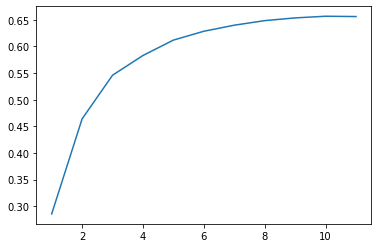

In [41]:
sf = pd.DataFrame(sfs1.subsets_).T

plt.plot(sf['avg_score'])
plt.show()

In [42]:
lr = LinearRegression()
sfs1 = sfs(lr, k_features = 9, cv = 3, scoring = 'r2', verbose = 0)
sfs1.fit(X,y)

SequentialFeatureSelector(clone_estimator=True, cv=3,
                          estimator=LinearRegression(copy_X=True,
                                                     fit_intercept=True,
                                                     n_jobs=None,
                                                     normalize=False),
                          fixed_features=None, floating=False, forward=True,
                          k_features=9, n_jobs=1, pre_dispatch='2*n_jobs',
                          scoring='r2', verbose=0)

In [44]:
cols = list(sfs1.k_feature_names_)


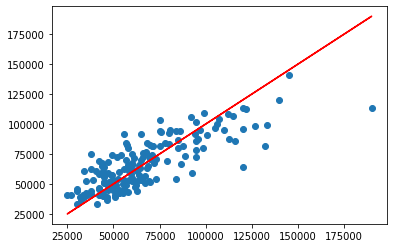

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size = 0.3, random_state = 3)

lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)

plt.scatter(y_test, y_test_pred)
plt.plot(y_test, y_test, 'r')

### Regularization

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print('r-squared of Train: ', r2_score(y_train, y_train_pred))
print('r-squared of Test: ', r2_score(y_test, y_test_pred))

r-squared of Train:  0.6834303298559896
r-squared of Test:  0.6368778022054269


In [48]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

In [49]:
alphas = np.linspace(0.001, 1, 100)
lasso_cv = LassoCV(alphas = alphas, cv = 3, random_state = 3)
lasso_cv.fit(X, y)

LassoCV(alphas=array([0.001     , 0.01109091, 0.02118182, 0.03127273, 0.04136364,
       0.05145455, 0.06154545, 0.07163636, 0.08172727, 0.09181818,
       0.10190909, 0.112     , 0.12209091, 0.13218182, 0.14227273,
       0.15236364, 0.16245455, 0.17254545, 0.18263636, 0.19272727,
       0.20281818, 0.21290909, 0.223     , 0.23309091, 0.24318182,
       0.25327273, 0.26336364, 0.27345455, 0.28354545, 0.29363636,
       0.30372727, 0....
       0.80827273, 0.81836364, 0.82845455, 0.83854545, 0.84863636,
       0.85872727, 0.86881818, 0.87890909, 0.889     , 0.89909091,
       0.90918182, 0.91927273, 0.92936364, 0.93945455, 0.94954545,
       0.95963636, 0.96972727, 0.97981818, 0.98990909, 1.        ]),
        copy_X=True, cv=3, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=3, selection='cyclic', tol=0.0001,
        verbose=False)

In [50]:
lasso_cv.alpha_

0.001

Best Alpha is hitting the lowest. This indicate that this model doesn't require Lasso regularization

### Ridge Regularization

In [52]:
alphas = np.logspace(-4, 0, 200)

ridge_cv = RidgeCV(alphas = alphas, scoring = 'r2', store_cv_values = True)

ridge_cv.fit(X, y)


RidgeCV(alphas=array([1.00000000e-04, 1.04737090e-04, 1.09698580e-04, 1.14895100e-04,
       1.20337784e-04, 1.26038293e-04, 1.32008840e-04, 1.38262217e-04,
       1.44811823e-04, 1.51671689e-04, 1.58856513e-04, 1.66381689e-04,
       1.74263339e-04, 1.82518349e-04, 1.91164408e-04, 2.00220037e-04,
       2.09704640e-04, 2.19638537e-04, 2.30043012e-04, 2.40940356e-04,
       2.52353917e-04, 2.64308149e-0...
       4.15040476e-01, 4.34701316e-01, 4.55293507e-01, 4.76861170e-01,
       4.99450512e-01, 5.23109931e-01, 5.47890118e-01, 5.73844165e-01,
       6.01027678e-01, 6.29498899e-01, 6.59318827e-01, 6.90551352e-01,
       7.23263390e-01, 7.57525026e-01, 7.93409667e-01, 8.30994195e-01,
       8.70359136e-01, 9.11588830e-01, 9.54771611e-01, 1.00000000e+00]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring='r2', store_cv_values=True)

In [53]:
ridge = Ridge(alpha = ridge_cv.alpha_, random_state = 3)

ridge.fit(X_train, y_train)

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

print('r-squared of Train: ', r2_score(y_train, y_train_pred))
print('r-squared of Test: ', r2_score(y_test, y_test_pred))

r-squared of Train:  0.6834303298555318
r-squared of Test:  0.6368777428752552
